# Libraries

In [1]:
import os
import pickle

import math

import numpy as np

import torch
import torch.nn as nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

# Global Vars

In [34]:
batch_size = 2 # how many predictions the model can make in parallel
block_size = 5 # context length
token_embedding_size = 384
n_embd = token_embedding_size
dropout = 0.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Importing Data, Token -> Integer mapping, and Batching

In [4]:

'''
Creates the char to int token embedding based on the file chosen.

based on:
https://github.com/karpathy/nanoGPT/blob/master/data/shakespeare_char/prepare.py
https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py
'''

# get the text from the text file
input_file_path = "./data/tinyshakespeare.txt"
with open(input_file_path, 'r') as f:
    data = f.read()
print(f"num characters in dataset: {len(data):,}")

# get all the unique characters
chars = sorted(set(data))
print(f"length of dataset in characters: {len(data):,}")

# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits from the text file
encoded_data = torch.tensor(encode(data), dtype=torch.long)
n = int(len(encoded_data)*0.9)
train_data = encoded_data[:n]
val_data = encoded_data[n:]

print(f"train has {len(train_data):,} tokens")
print(f"val has {len(val_data):,} tokens")


num characters in dataset: 1,115,394
length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens


In [37]:
def get_batch(split):
    '''
    Generates two tensors. Each of size (batch, block).
    x is [batch] character sequences of length [block], each character encoded as a token/int.
    y is the targets of the character sequences in x.
    For example, for x=[abcde,fghij], y=[bcdef,ghijk],
    given the sequence x[n][:m], you want to predict y[n][m]
    '''
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [59]:
x, y = get_batch("train")
print(x)
print(y)

tensor([[ 1, 41, 53, 59, 50],
        [ 0,  0, 29, 33, 17]])
tensor([[41, 53, 59, 50, 42],
        [ 0, 29, 33, 17, 17]])


# Token Embeddings and Position Encodings

In [5]:
# Token and Position Embeddings
token_embedding_table = nn.Embedding(vocab_size, token_embedding_size)

def compute_positional_encoding(pos, dim, d_model):
    '''
    Here are the formulas for the positional encodings from the paper
      PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
      PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    
    PE(pos, 2i) is for the even elements of the position encoding.
    pos is the position in the sequence
    d_model is the length of the position encoding
    2i or 2i+1 is the element index into the position encoding
    '''
    if (dim % 2) == 0:
        pe = math.sin(pos / (10000 ** (dim / d_model)))
    else:
        pe = math.cos(pos / (10000 ** ((dim - 1) / d_model)))
    return pe

def generate_positional_encodings(seq_len, d_model):
    '''
    This function uses the compute_positional_encoding function
    to generate the (block, embed_dim) positional encoding.
    This is added to each batch in the (batch, block, embed_dim) token embedding.
    '''
    pe = torch.zeros(seq_len, d_model)
    for pos in range(seq_len):
        for dim in range(d_model):
            pe[pos, dim] = compute_positional_encoding(pos, dim, d_model)
    return pe

def positional_encoding(seq_len, d_model):
    # Create a positional encoding matrix of shape (seq_len, d_model)
    # This is a more efficient way of doing generate_positional_encodings,
    # although it generates slightly different due to floating pt calculations.
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0.0, d_model, 2) * -(math.log(10000.0) / d_model))
    
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    
    return pe

def embeddings(x):
    #x: (batch, block), each batch is a list of integers.
    #token embeddings (batch, block, embedding_dim)
    token_embeddings = token_embedding_table(x)
    batch, block, embedding_dim = token_embeddings.shape
    #positional encoding (block, embedding_dim)
    positional_encodings = positional_encoding(block, embedding_dim)
    #add the positional encoding to every batch.
    return token_embeddings + positional_encodings


In [62]:
x, y = get_batch("train")
z = embeddings(x)
print(z)

tensor([[[-0.0909,  0.2569,  0.0254,  ...,  0.2936,  1.3609,  0.9250],
         [ 1.6292, -0.2421,  0.6794,  ...,  1.4893,  0.6341,  1.3685],
         [-0.7493, -1.4487,  1.3906,  ...,  1.2283,  0.5427,  1.0755],
         [ 0.9133, -1.9406,  2.8327,  ...,  0.5540, -0.3253,  1.5460],
         [ 0.0154, -1.6042,  1.9325,  ...,  0.5540, -0.3252,  1.5460]],

        [[ 1.8882,  1.1989,  1.6346,  ..., -0.0656, -0.0731, -0.1586],
         [ 2.3591, -0.4629,  2.1529,  ..., -1.3799, -1.3144,  0.6742],
         [ 0.8493,  0.8104, -0.1283,  ...,  0.4572,  0.8704,  2.1054],
         [ 0.6559, -1.4095,  0.4233,  ...,  2.2858,  0.0920, -0.0469],
         [ 0.8315, -1.7669, -0.1141,  ..., -1.3999, -1.4239,  1.7783]]],
       grad_fn=<AddBackward0>)


tensor(-1.)
tensor(1.)


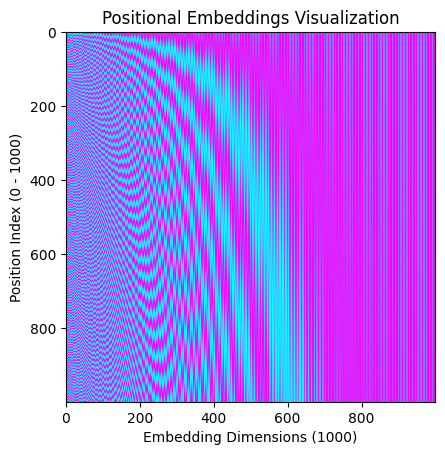

In [28]:
edn = 1000
dn = 1000
pe = positional_encoding(edn, dn)
print(torch.min(pe))
print(torch.max(pe))
# normalize the tensor to 0-1 range
pe = (pe - torch.min(pe)) / (torch.max(pe) - torch.min(pe))
plt.imshow(pe, cmap='cool', interpolation='nearest')
plt.xlabel(f'Embedding Dimensions ({edn})')
plt.ylabel(f'Position Index (0 - {dn})')
plt.title('Positional Embeddings Visualization')
plt.show()

# Scaled and Masked Dot-Product Attention

So far:
batches of text
-> batches of integers/tokens
-> batches of token + position embeddings
Say we have an x of shape (batch, embeddings, embed_dims).
How do we get the q, k, and v for the attention input?
Answer not in paper -> using Andrej Karpathy's solution as a guide.

In [35]:
#copied from GPT-dev colab notebook
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x is the input -> it is the (batch_size, sequence_length, n_embd).
        B,T,C = x.shape

        # these 2 lines generate the keys and queries for every token in x.
        # if x is (batch_size, sequence_length, n_embd), then q and k will be (batch_size, sequence_length, head_size).
        # a linear layer is applied to every token embedding to get the key/query.
        # note that later layers it won't be token embeddings as input, but the output of the previous layer.
        k = self.key(x)
        q = self.query(x)

        # implements the \frac{QK^T}{\sqrt{d_k}} part of the paper
        # computes the dot product between every key and query using matmul
        # wei is the matrix of weights, where cell_ij is the dot product between key_i and query_j (not sure if i is row or column)
        # each dot product represents how "similar" the key and query is - the higher the more similar.
        # this is done for every batch, so there are [batch] seq_len by seq_len matrices
        # wei is (batch_size, sequence_length, sequence_length)
        # we scale the results with sqrt(n_embed) to prevent dot products from growing (see page 4 of the paper.)
        wei = q @ k.transpose(-2,-1) * C**-0.5

        # remember that later on we'll multiple the weight matrix with the token's "values"
        # in essence, token i will "query" all other tokens.
        # if token j's key is similar to the query, a high weight is applied to the token j's value vector.
        # so token i will generate a vector composed of all the value vectors in the sequence summed together,
        # weighted by the query_i/key_j similarity score.

        # however, we want to prevent token i from looking at token i + 1
        # this is so when we use tokens [0, 1, 2] to predict token 3 (during training), we don't wan't them looking at token 3 or 4 or ...
        # to prevent this, we set the weights for tokens i + 1 and above to 0, so they aren't included in that weighted values vector.
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

        # softmax the weights so the sum of the weights goes to 1.
        wei = F.softmax(wei, dim=-1)

        # dropout some weights during training can be a good idea.
        wei = self.dropout(wei)

        # generate the values for each token
        v = self.value(x)
        # perform the weighted aggregation of the values
        out = wei @ v
        # returns a tensor of size (batch_size, sequence_length, head_size)
        # where each token is replaced by a weighted sum of "all" the other tokens (values) based on q-k similarity
        return out

In [39]:
torch.tril(torch.ones(5, 5))

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

In [38]:
head = Head(10)
x, y = get_batch("train")
z = embeddings(x)
head.forward(z)

torch.Size([2, 5, 384])
torch.Size([2, 5, 10])
